In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

In [2]:
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv"
df = pd.read_csv(url)

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [6]:
# 특성과 레이블 분리
X = df.drop(columns='BMI')
y = df['BMI']

In [7]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,0.627,50,1
1,1,85,66,29,0,0.351,31,0
2,8,183,64,0,0,0.672,32,1
3,1,89,66,23,94,0.167,21,0
4,0,137,40,35,168,2.288,33,1


In [8]:
y.head()

0    33.6
1    26.6
2    23.3
3    28.1
4    43.1
Name: BMI, dtype: float64

In [ ]:
# 정규화    
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((614, 8), (614,), (154, 8), (154,))

In [12]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

In [13]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# 모델 정의
class BMIRegressor(nn.Module):
    def __init__(self):
        super(BMIRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [15]:
model = BMIRegressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# 학습
epochs = 200
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 20/200, Loss: 53.3362
Epoch 40/200, Loss: 39.8347
Epoch 60/200, Loss: 32.7980
Epoch 80/200, Loss: 30.5877
Epoch 100/200, Loss: 30.7183
Epoch 120/200, Loss: 27.8029
Epoch 140/200, Loss: 26.7062
Epoch 160/200, Loss: 25.8763
Epoch 180/200, Loss: 25.7264
Epoch 200/200, Loss: 24.5768


In [18]:
# 평가
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    y_true = y_test_tensor.numpy()

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest MSE: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")


Test MSE: 58.1881
Test R^2 Score: 0.1814


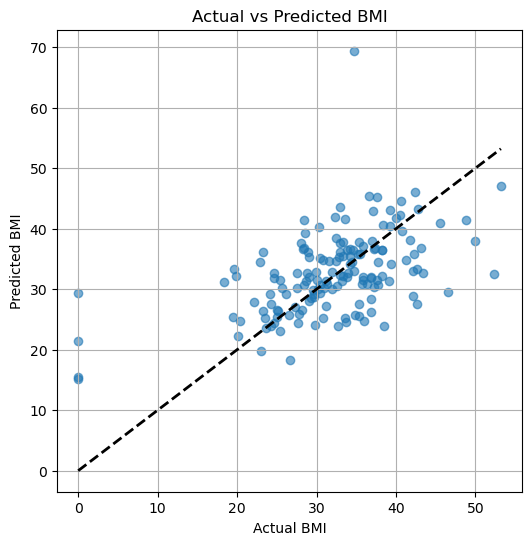

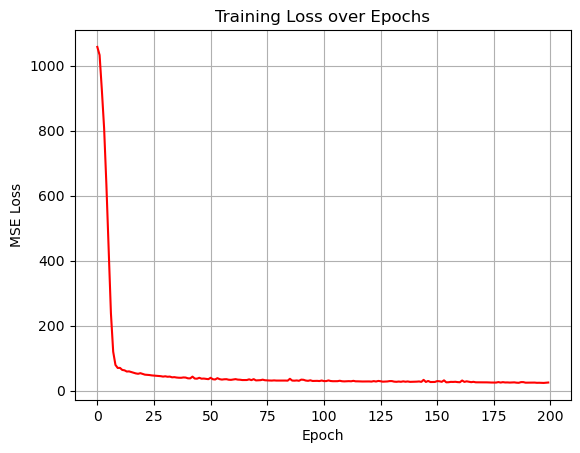

In [19]:
# 예측 vs 실제 그래프
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.title("Actual vs Predicted BMI")
plt.grid(True)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
plt.show()

# Loss 시각화
plt.figure()
plt.plot(train_losses, color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()
